# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

from collections import Counter
from itertools import cycle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Parsing images from dataframe
def parse_data(data: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
# Plotting images
def show_img(images: np.ndarray, labels: np.ndarray, emotions: dict) -> None:
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}, Emotion: {}".format(label, emotions[label]))
    plt.tight_layout()
    plt.show()

In [ ]:
## Load dataset here
df = pd.read_csv("../data/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
## Parsing data here
images, labels = parse_data(df)

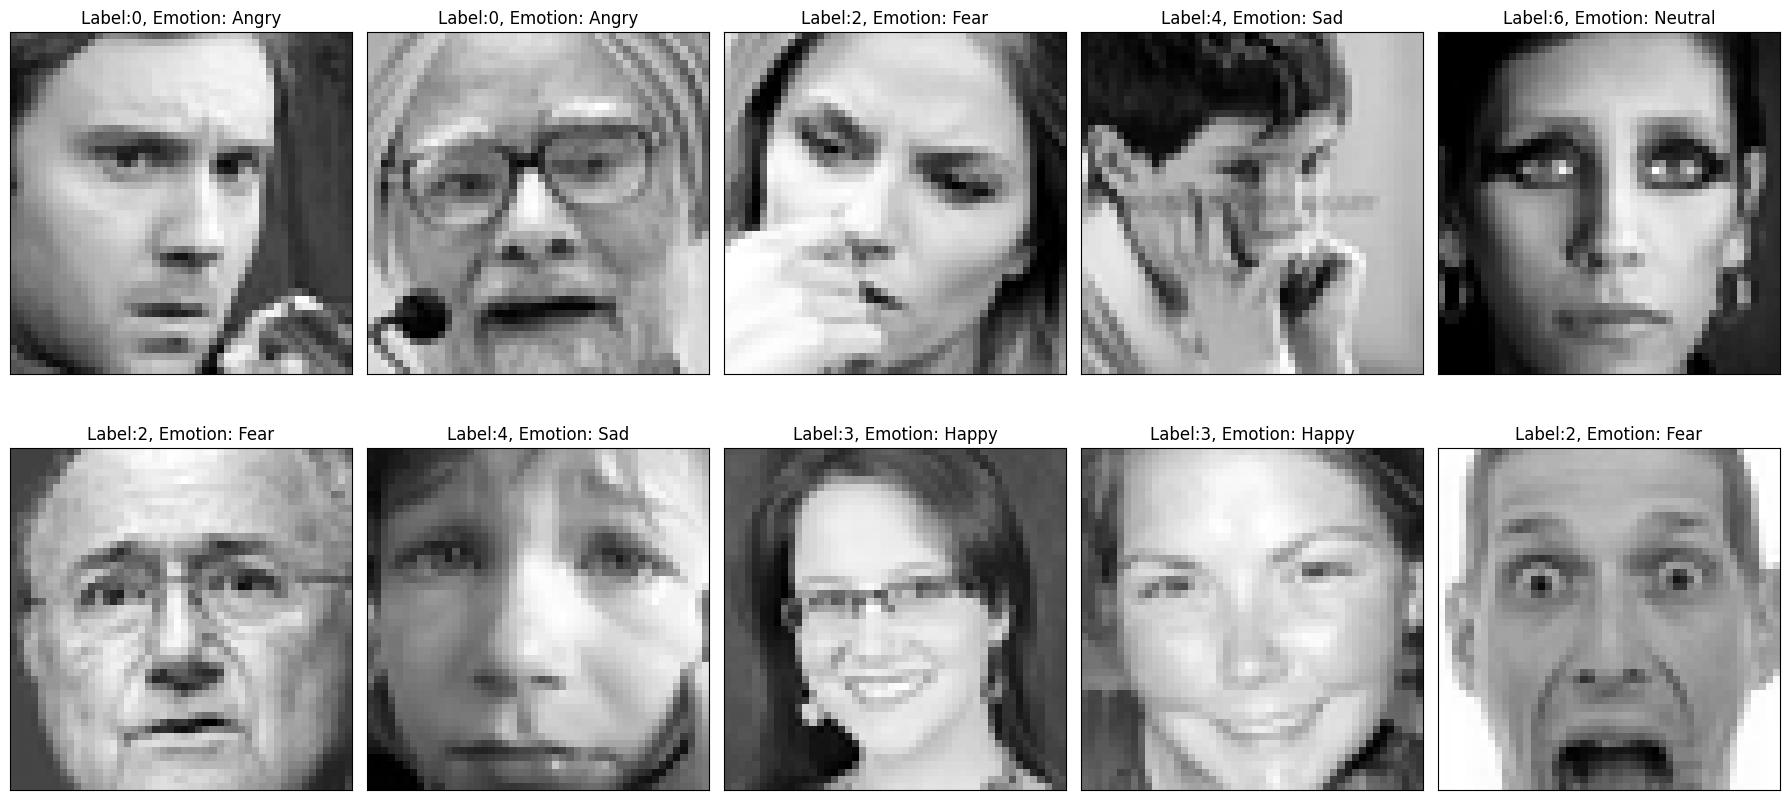

In [ ]:
## Showing images here
emotions = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}
show_img(images, labels, emotions)

We can normalize the values to range from 0 to 1 by dividing each pixel value by 255. In this way, the numbers will be small and the computation becomes easier and faster. Therefore, the model will converge faster.

In [ ]:
images = images / 255.0

Checking the distribution of each class in the labels, we can observe that the amount of each class is very skewed. Therefore, this is an imbalanced dataset.

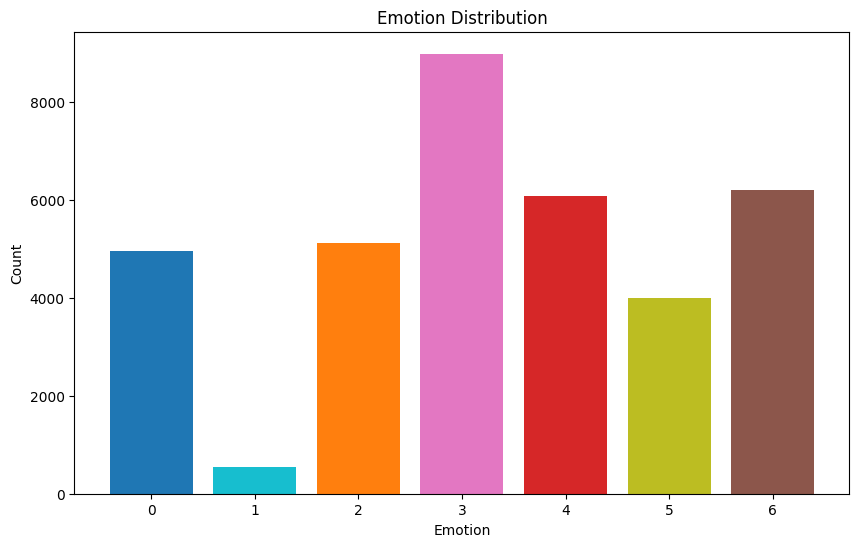

In [ ]:
# Checking distribution of labels
num_classes = len(np.unique(labels))

# Define colors for each class
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

# Count the occurrences of each class
class_counts = Counter(labels)

# Plot the distribution and add legend
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.xticks(range(num_classes))
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Distribution')
plt.show()

- Class 3 (Label 3) has the highest count, indicating that this particular emotion is the most frequent in the dataset.
It significantly stands out with a count close to 9000.

- Class 1 (Label 1) has the lowest count, making it the least frequent emotion in the dataset.It has a count significantly lower than the others, indicating a possible imbalance.

- Other classes (0, 2, 4, 5, 6) have varying counts, with some having moderate frequencies and others being closer to the extremes.
Classes 0, 2, 4, and 6 have similar counts, ranging between approximately 4000 to 6000.
Class 5 has a relatively lower count compared to most, except for class 1.



- The dataset appears to be **imbalanced**, with a wide disparity between the counts of the most frequent and least frequent classes.
This imbalance might need to be addressed in modeling to ensure that the model doesn't become biased towards the more frequent classes.


- For classification tasks, techniques such as class weighting, oversampling the minority classes, or undersampling the majority classes might be necessary to handle the imbalance.
Evaluating the model using metrics like precision, recall, and F1-score, rather than accuracy alone, could provide a better understanding of the model performance across all classes.

In [ ]:
# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

X_train_org = X_train.copy()
X_test_org = X_test.copy()

X_train_org = X_train_org.reshape(X_train_org.shape[0], -1)
X_test_org = X_test_org.reshape(X_test_org.shape[0], -1)

In [ ]:
# Printing out shape
print(f'Train Images Shape:{X_train_org.shape}')
print(f'Train Lables Shape:{y_train.shape}')
print(f'Test Images Shape:{X_test_org.shape}')
print(f'Test Lables Shape:{y_test.shape}')

Train Images Shape:(28709, 2304)
Train Lables Shape:(28709,)
Test Images Shape:(7178, 2304)
Test Lables Shape:(7178,)


In [ ]:
# Reshape the dataset
X_train_processed = X_train.reshape(X_train.shape[0], -1)
X_test_processed = X_test.reshape(X_test.shape[0], -1)

The dataset is imbalanced, so that we need to handle this using SMOTE and Tomek Links.
- SMOTE is an oversampling method that synthesizes new plausible examples in the minority class.
- Tomek Links refers to a method for identifying pairs of nearest neighbors in a dataset that have different classes. Removing one or both of the examples in these pairs (such as the examples in the majority class) has the effect of making the decision boundary in the training dataset less noisy or ambiguous.
- Specifically, first the SMOTE method is applied to oversample the minority class to a balanced distribution, then examples in Tomek Links from the majority classes are identified and removed.

In [ ]:
# Handling imbalanced dataset using comnination of SMOTE and Tomek Links
sm = SMOTE(
    sampling_strategy='minority',
    random_state=42,
    k_neighbors=5,
)

tl = TomekLinks(
    sampling_strategy='all',
    n_jobs=4
)

smtomek = SMOTETomek(
    sampling_strategy='all',
    random_state=42,
    smote=sm,
    tomek=tl,
)

X_train_processed, y_train_processed = smtomek.fit_resample(X_train_processed, y_train)

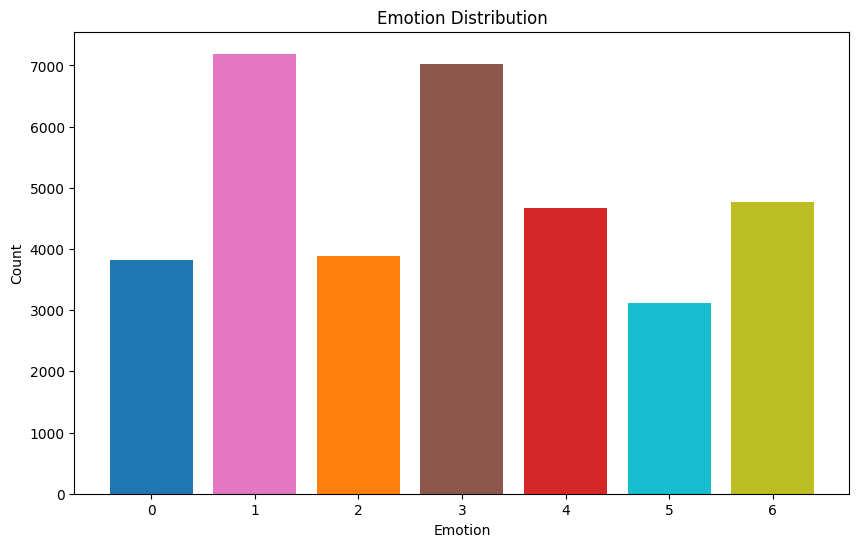

In [ ]:
# Checking distribution of labels after handling imbalance
# Define colors for each class
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

# Count the occurrences of each class
class_counts = Counter(y_train_processed)

# Plot the distribution and add legend
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.xticks(range(num_classes))
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Distribution')
plt.show()

From the count plot of the new dataset (processed with SMOTE and TomekLinks), we can come to the conclusion that:

- Improved Balance: The distribution appears more balanced compared to typical imbalanced datasets. Classes 0, 1, 2, 3, 4, 5, and 6 have relatively close counts, indicating that the application of SMOTE (Synthetic Minority Over-sampling Technique) and TomekLinks has successfully addressed class imbalance.

- Reduced Risk of Overfitting: With more samples, the model is less likely to overfit the more common classes as it can learn the features more generally.
Classes with more samples help the model learn diverse features, increasing its generalizability when applied to new data.

In [ ]:
# Convert shape back to 2D
X_train_processed = X_train_processed.reshape(X_train_processed.shape[0], 48, 48)
X_test_processed = X_test_processed.reshape(X_test_processed.shape[0], 48, 48)

## Feature Extraction with HOG


**HOG (Histogram of Oriented Gradients)** is a feature descriptor that extracts information from an image by computing the gradient magnitude and orientation at each pixel . These values are then grouped into cells and a histogram of gradient orientations is created for each cell . This can benefit a model in various advantages as:

- Robustness to Illumination and Shadowing

- Invariance to Geometric Transformations

- Effective for Object Detection

- Good Performance with SVM



In [ ]:
# Extract features with HOG
def extract_hog_features(images: np.ndarray) -> np.ndarray:
    """
    Extracts HOG features from an array of images.
    """
    hog_features = []
    orientations=7
    pixels_per_cell=(8, 8)
    cells_per_block=(2, 2)
    block_norm='L2-Hys'
    transform_sqrt=False
    for image in images:
        fd = hog(
            image,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm=block_norm,
            transform_sqrt=transform_sqrt
        )
        hog_features.append(fd)
    return np.array(hog_features)

X_train_processed = extract_hog_features(X_train_processed)
X_test_processed = extract_hog_features(X_test_processed)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

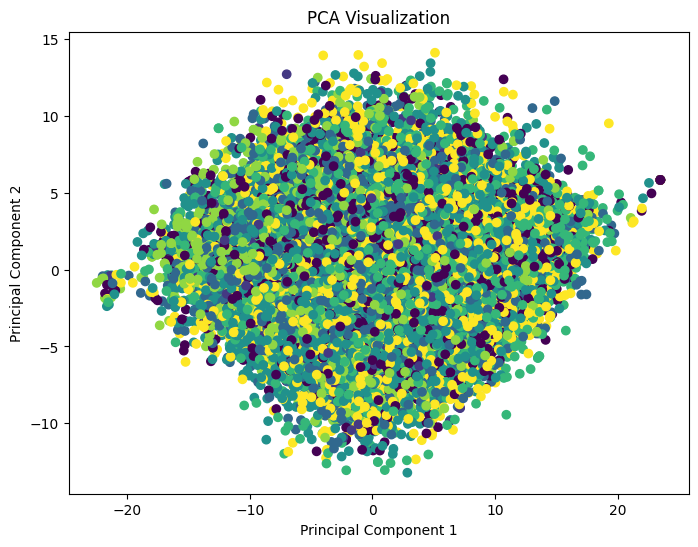

In [ ]:
from sklearn.decomposition import PCA

# Applying PCA to retain two principle components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(images.reshape(images.shape[0], -1))

# Visualize the data projected onto two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.show()

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

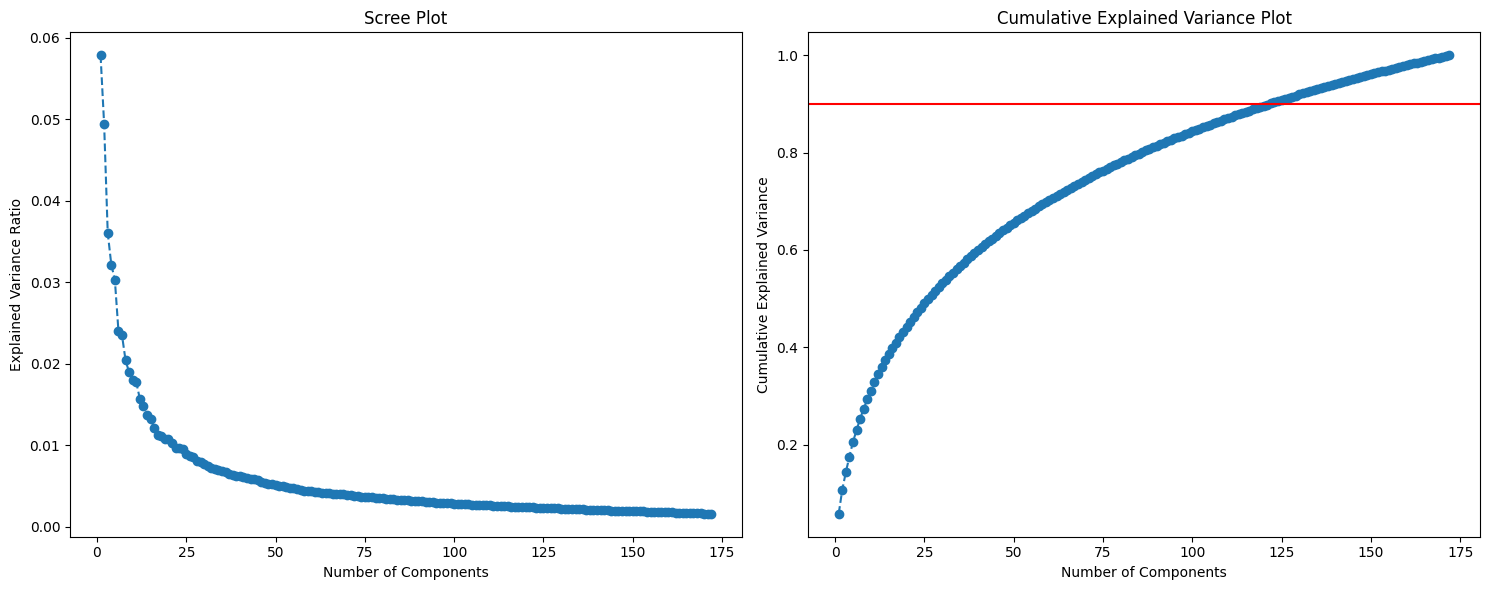

In [ ]:
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(np.concatenate((X_train_processed, X_test_processed), axis=0))

# Calculate variance ratio
explained_variance = pca.explained_variance_ratio_

# Create subplots with one row and two columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scree Plot
ax1.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree Plot')

# Cumulative Explained Variance Plot
cumulative_explained_variance = np.cumsum(explained_variance)
ax2.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance Plot')
ax2.axhline(y=0.90, color='r', linestyle='-')  # 90% explained variance line

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

In [ ]:
# Find out numbers of principle components to retain 90% cummulative variance
optimal_k = np.argmax(cumulative_explained_variance >= 0.90) + 1
print(f'Optimal number of components to retain 90% of the variance: {optimal_k}')

Optimal number of components to retain 90% of the variance: 122


Determining the optimal number of principal components using `pca.explained_variance_` by following these steps:

- **Scree Plot Analysis:**
    - The scree plot (left plot) which shows the explained variance ratio for each principal component. The "elbow" point in the scree plot is often considered an indicator of the optimal number of components. This point is where the explained variance starts to diminish at a much slower rate. 
    - In the scree plot, the elbow appears around the first few components (where there is a noticeable drop in the explained variance ratio).

- **Cumulative Explained Variance:**
    - The cumulative explained variance plot (right plot) helps to determine how many components are needed to explain a desired amount of variance in the data.
    - Generally, the number of components that reach a cumulative explained variance close to 90-95% (indicated by the red line in the plot) which is 122 components in this case, is considered a good choice for dimensionality reduction.

We determine to choose the number of components that explain at least 90% of the variance in the data by using **Cumulative Explained Variance:** method. In this case, 122 components are selected to achieve a cumulative explained variance close to 95%.

In [ ]:
# Implementing PCA
pca = PCA(n_components=optimal_k)
X_train_processed = pca.fit_transform(X_train_processed)
X_test_processed = pca.transform(X_test_processed)

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

Due to resource constraints, such as limited computational capacity and available space, we were unable to conduct ```GridSearchCV``` for our models in our this project. Instead, we opted for other methods as each member will execute the tuning task by themself and contribute to the group project's report.

In [ ]:
# Define a dictionary to store trained model
algorithms = {}

### 3.1 Extreme Gradient Boosting Classifier

```XGBoost``` is an advanced implementation of gradient boosting algorithms, known for its speed and performance. It uses an ensemble of weak prediction models, typically decision trees, to sequentially minimize the prediction error. In image classification tasks, XGBoost can be effective when features are manually extracted or when dealing with structured data derived from images.

In [ ]:
# Define the model
xgb = XGBClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'objective': ['multi:softmax'],
    'num_class': [num_classes],
    'n_estimators': [100, 200],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'eval_metric': ['mlogloss' if num_classes > 2 else 'merror']
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'eval_metric': ['mlogloss'],
                         'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                         'max_depth': [3, 5], 'n_estimators': [100, 200],
                         'num_class': [7], 'objective': ['multi:softmax'],
                         'subsample': [0.8, 1.0]},
             verbose=2)

#### 3.1.1 Best parameters model with original data

In [ ]:
grid_search.fit(X_train_org, y_train)

In [ ]:
# Training the model with best params
best_params = {
    'objective': 'multi:softmax',
    'num_class': 7,
    'n_estimators': 100,
    'learning_rate': 0.01,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree' : 0.8,
    'eval_metric': 'mlogloss',
}

xgb_org = XGBClassifier(**best_params, random_state=42)
xgb_org.fit(X_train_org, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=7, num_parallel_tree=None, ...)

In [ ]:
y_pred_xgb_org = xgb_org.predict(X_test_org)
accuracy_xgb_org = accuracy_score(y_test, y_pred_xgb_org)
print(f"XGBoost Accuracy on Original Data: {accuracy_xgb_org * 100:.2f}%")

XGBoost Accuracy on Original Data: 34.42%


#### 3.1.2 Best parameters model with processed data

In [ ]:
grid_search.fit(X_train_processed, y_train_processed)

In [ ]:
# Training the model with best params
best_params = {
    'objective': 'multi:softmax',
    'num_class': 7,
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
    'eval_metric': 'mlogloss',
}

xgb_processed = XGBClassifier(**best_params, random_state=42)
xgb_processed.fit(X_train_processed, y_train_processed)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=7, num_parallel_tree=None, ...)

In [ ]:
y_pred_xgb_processed = xgb_processed.predict(X_test_processed)
accuracy_xgb_processed = accuracy_score(y_test, y_pred_xgb_processed)
print(f"XGBoost Accuracy on Processed Data: {accuracy_xgb_processed * 100:.2f}%")

XGBoost Accuracy on Processed Data: 44.54%


### 3.2 Supper Vector Classifier

```SVC``` is a supervised learning model used for classification tasks. It finds the optimal hyperplane in a high-dimensional space that best separates classes by maximizing the margin between them. In image classification, SVCs can classify images based on extracted features, especially in scenarios where there are complex decision boundaries.

In [ ]:
# Define the model
svc = SVC(random_state=42)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma':['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search

GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

#### 3.2.1 Best parameters model with original data

In [ ]:
# Running hyperparamter tuning
grid_search.fit(X_train_org, y_train)

In [ ]:
# Training the model with best params
best_params = {
    'C': 1,
    'gamma': 'scale',
    'kernel': 'rbf'
}

svm_org = SVC(**best_params, random_state=42, probability=True)
svm_org.fit(X_train_org, y_train)

SVC(C=1, random_state=42)

In [ ]:
y_pred_svm_org = svm_org.predict(X_test_org)
accuracy_svm_org = accuracy_score(y_test, y_pred_svm_org)
print(f"SVM Accuracy on Original Data: {accuracy_svm_org * 100:.2f}%")

SVM Accuracy on Original Data: 44.62%


#### 3.2.2 Best parameters model with processed data

In [ ]:
grid_search.fit(X_train_processed, y_train_processed)

In [ ]:
# Training the model with best params
best_params = {
    'C': 10,
    'gamma': 'scale',
    'kernel': 'rbf'
}

svm_processed = SVC(**best_params, random_state=42, probability=True)
svm_processed.fit(X_train_processed, y_train_processed)

SVC(C=10, probability=True, random_state=42)

In [ ]:
y_pred_svm_processed = svm_processed.predict(X_test_processed)
accuracy_svm_processed = accuracy_score(y_test, y_pred_svm_processed)
print(f"SVM Accuracy on Processed Data: {accuracy_svm_processed * 100:.2f}%")

SVM Accuracy on Processed Data: 56.98%


### 3.3 Random Forest Classifier


```Random Forest``` is an ensemble learning method that builds multiple decision trees and combines their predictions to improve accuracy. It's effective for image classification due to its robustness against overfitting and ability to handle high-dimensional data like image features.

In [ ]:
# Define the model
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

#### 3.3.1 Best parameters model with original data

In [ ]:
# Running hyperparamter tuning
grid_search.fit(X_train_org, y_train)

In [ ]:
# Training the model with best params
best_params = {
    'n_estimators': 200,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt'
}

rf_org = RandomForestClassifier(
    **best_params,
    random_state=42,
    bootstrap=False,
    n_jobs=-1
)

rf_org.fit(X_train_org, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.4min finished


RandomForestClassifier(bootstrap=False, n_estimators=200, n_jobs=-1,
                       random_state=42, verbose=1)

In [ ]:
# Evaluating performance of the model
y_pred_rf_org = rf_org.predict(X_test_org)
accuracy_rf_org = accuracy_score(y_test, y_pred_rf_org)
print(f"Random Forest Accuracy on Original Data: {accuracy_rf_org * 100:.2f}%")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s


Random Forest Accuracy on Original Data: 48.69%


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished


#### 3.3.2 Best parameters model with proceesed data

In [ ]:
# Running hyperparamter tuning
grid_search.fit(X_train_processed, y_train_processed)

In [ ]:
# Training the model with best params
best_params = {
    'n_estimators': 200,
    'max_depth': None,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt'
}

rf_processed = RandomForestClassifier(
    **best_params,
    random_state=42,
    bootstrap=False,
    n_jobs=-1,
)

rf_processed.fit(X_train_processed, y_train_processed)

RandomForestClassifier(bootstrap=False, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
# Evaluating performance of the model
y_pred_rf_processed = rf_processed.predict(X_test_processed)
accuracy_rf_processed = accuracy_score(y_test, y_pred_rf_processed)
print(f"Random Forest Accuracy on Processed Data: {accuracy_rf_processed * 100:.2f}%")

Random Forest Accuracy on Processed Data: 47.88%


### 3.4 Multi-layer Perceptron Classifier

```MLP``` is a type of artificial neural network characterized by multiple layers of nodes (neurons), each layer fully connected to the next one. It can learn complex relationships between features and target outputs through backpropagation and gradient descent. In image classification, MLPs are effective when used with deep learning frameworks like TensorFlow or PyTorch to directly process image pixel data, learning hierarchical features at different levels.

In [ ]:
# Define MLP model
def create_mlp(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Define optimizer and loss function
optimizer = 'adam'
loss = 'categorical_crossentropy'

# Define hyperparameter
batch_size = 64
epochs = 10

#### 3.4.1 Best parameters model with original data

In [ ]:
# Define input and model
input_shape = (X_train_org.shape[1],)

# Convert labels to one-hot encoding
y_train_mlp = to_categorical(y_train)
y_test_mlp = to_categorical(y_test)

In [ ]:
tf.config.run_functions_eagerly(True)

# Define model
mlp_org = create_mlp(input_shape, num_classes)

# Compile the model
mlp_org.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
# Model Training
mlp_org.fit(X_train_org, y_train_mlp, epochs=epochs, batch_size=batch_size, validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
359/359 [==============================] - 27s 76ms/step - loss: 2.2429 - accuracy: 0.2163 - val_loss: 1.7648 - val_accuracy: 0.3015
Epoch 2/10
359/359 [==============================] - 26s 71ms/step - loss: 1.8164 - accuracy: 0.2863 - val_loss: 1.7477 - val_accuracy: 0.2842
Epoch 3/10
359/359 [==============================] - 27s 76ms/step - loss: 1.7234 - accuracy: 0.3174 - val_loss: 1.6857 - val_accuracy: 0.3325
Epoch 4/10
359/359 [==============================] - 26s 74ms/step - loss: 1.7032 - accuracy: 0.3231 - val_loss: 1.7303 - val_accuracy: 0.3084
Epoch 5/10
359/359 [==============================] - 32s 88ms/step - loss: 1.6960 - accuracy: 0.3268 - val_loss: 1.7076 - val_accuracy: 0.3178
Epoch 6/10
359/359 [==============================] - 28s 78ms/step - loss: 1.6883 - accuracy: 0.3293 - val_loss: 1.7516 - val_accuracy: 0.3074
Epoch 7/10
359/359 [==============================] - 36s 100ms/step - loss: 1.7174 - accuracy: 0.3108 - val_loss: 1.7186 - val_accuracy

In [ ]:
# Evaluating performance of the model
y_pred_mlp_org = mlp_org.predict(X_test_org)
accuracy_mlp_org = accuracy_score(y_test, np.argmax(y_pred_mlp_org, axis=1))
print(f"MLP Accuracy on Original Data: {accuracy_mlp_org * 100:.2f}%")

225/225 [==============================] - 2s 7ms/step
MLP Accuracy on Original Data: 26.83%


#### 3.4.2 Best parameters model with processed data

In [ ]:
# Define input and model
input_shape = (X_train_processed.shape[1],)

# Convert labels to one-hot encoding
y_train_mlp = to_categorical(y_train_processed)
y_test_mlp = to_categorical(y_test)

In [ ]:
tf.config.run_functions_eagerly(True)

# Define model
mlp_processed = create_mlp(input_shape, num_classes)

# Compile the model
mlp_processed.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
# Model Training
mlp_processed.fit(X_train_processed, y_train_mlp, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


431/431 [==============================] - 31s 71ms/step - loss: 2.0874 - accuracy: 0.2695 - val_loss: 2.9440 - val_accuracy: 0.0091
Epoch 2/10
431/431 [==============================] - 30s 71ms/step - loss: 1.6401 - accuracy: 0.3619 - val_loss: 3.2012 - val_accuracy: 0.0096
Epoch 3/10
431/431 [==============================] - 31s 72ms/step - loss: 1.5640 - accuracy: 0.3889 - val_loss: 3.1566 - val_accuracy: 0.0102
Epoch 4/10
431/431 [==============================] - 32s 74ms/step - loss: 1.5253 - accuracy: 0.4098 - val_loss: 3.0313 - val_accuracy: 0.0104
Epoch 5/10
431/431 [==============================] - 30s 70ms/step - loss: 1.4999 - accuracy: 0.4168 - val_loss: 2.8961 - val_accuracy: 0.0305
Epoch 6/10
431/431 [==============================] - 32s 75ms/step - loss: 1.4811 - accuracy: 0.4272 - val_loss: 2.7930 - val_accuracy: 0.0621
Epoch 7/10
431/431 [==============================] - 30s 70ms/step - loss: 1.4675 - accuracy: 0.4318 - val_loss: 2.7362 - val_accuracy: 0.0776
Epo

In [ ]:
# Evaluating performance of the model
y_pred_mlp_processed = mlp_processed.predict(X_test_processed)
accuracy_mlp_processed = accuracy_score(y_test, np.argmax(y_pred_mlp_processed, axis=1))
print(f"MLP Accuracy on Processed Data: {accuracy_mlp_processed * 100:.2f}%")

225/225 [==============================] - 1s 7ms/step
MLP Accuracy on Processed Data: 46.50%


## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)

In this project, coming to classifier models, we will use **ROC (Receiver Operating Characteristic) curves and AUC (Area Under the Curve)** and **Confusion Matrix** to evaluate our models

In [ ]:
# Append to list of algorithms model
algorithms["xgb"] = (xgb_org, xgb_processed)
algorithms["svm"] = (svm_org, svm_processed)
algorithms["Random Forest Classifier"] = (rf_org, rf_processed)
algorithms["Multi-layers Perceptron Classifier"] = (mlp_org, mlp_processed)

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, ax, title):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Function to print classification
def print_classification(y_test, y_pred, title):
    print(f"{title} Classification Report:")
    print(classification_report(y_test, y_pred))

# Function to plot roc curve
def plot_roc_curve_multiclass(y_test, y_prob, n_classes, ax, title, emotions):
    # Binarize the labels for ROC curve computation
    y_test_bin = label_binarize(y_test, classes=range(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{emotions[i]} (AUC = {roc_auc[i]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(True)

# Function to evaluate and plot
def evaluate_and_plot(model, X_test, y_test, title_prefix, emotions, is_tf_model=False, is_plot_roc=True):
    if is_plot_roc:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(15, 6))

    # Evaluating model
    if is_tf_model:
        y_prob = model.predict(X_test)
        y_pred = np.argmax(y_prob, axis=1)
    else:
        if is_plot_roc:
            y_prob = model.predict_proba(X_test)
        y_pred = model.predict(X_test)

    # Classification report
    print_classification(y_test, y_pred, title_prefix)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    if is_plot_roc:
        plot_confusion_matrix(cm, ax=axes[0], title=f'{title_prefix} Confusion Matrix')
    else:
        plot_confusion_matrix(cm, ax=axes, title=f'{title_prefix} Confusion Matrix')

    # ROC Curve
    if is_plot_roc:
        plot_roc_curve_multiclass(y_test, y_prob, n_classes=num_classes, ax=axes[1], title=f'{title_prefix} ROC Curve', emotions=emotions)

    plt.tight_layout()
    plt.show()

### 4.1 XGBoost Classifier

In [ ]:
xgb_org, xgb_processed = algorithms["xgb"]

#### 4.1.1 Original Data

XGBoost Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.03      0.06       991
           1       1.00      0.01      0.02       109
           2       0.29      0.04      0.07      1024
           3       0.33      0.85      0.48      1798
           4       0.31      0.30      0.31      1216
           5       0.49      0.36      0.42       800
           6       0.35      0.17      0.23      1240

    accuracy                           0.34      7178
   macro avg       0.45      0.25      0.23      7178
weighted avg       0.36      0.34      0.28      7178



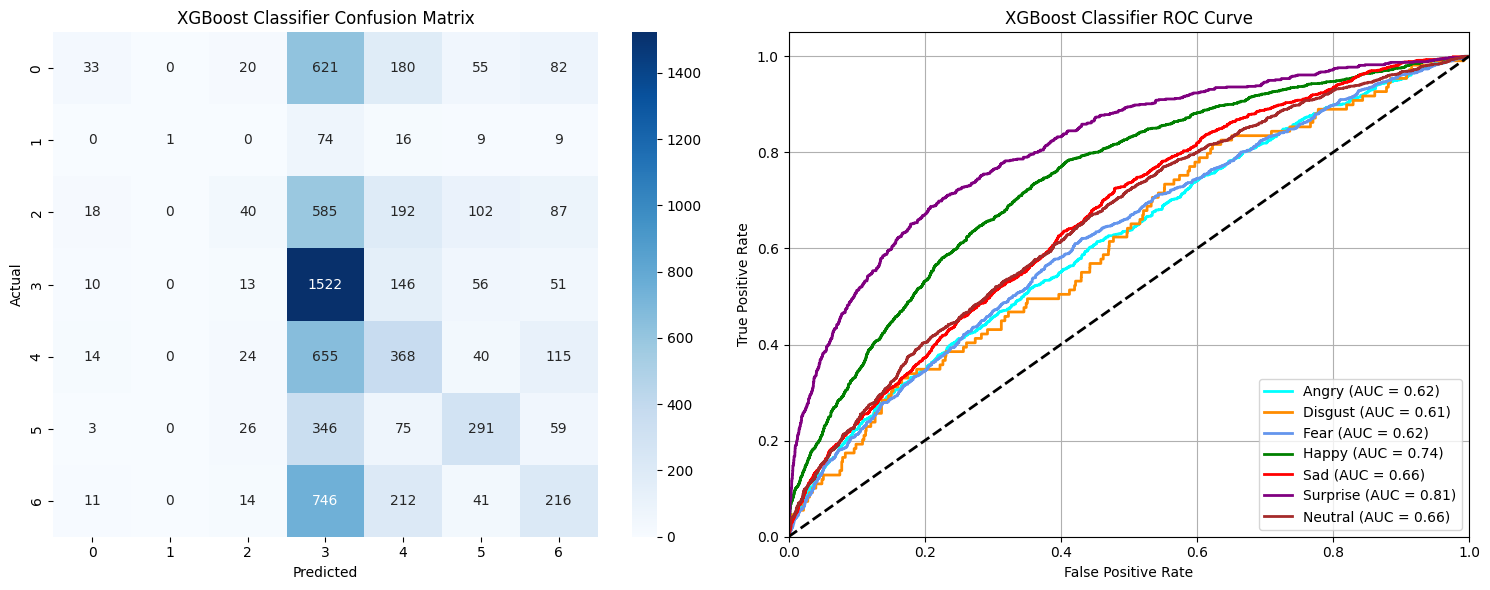

In [ ]:
evaluate_and_plot(xgb_org, X_test_org, y_test, title_prefix="XGBoost Classifier", emotions=emotions)

#### 4.1.2 Processed Data

XGBoost Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.21      0.29       991
           1       0.11      0.61      0.19       109
           2       0.40      0.20      0.27      1024
           3       0.54      0.79      0.64      1798
           4       0.35      0.31      0.33      1216
           5       0.60      0.55      0.57       800
           6       0.42      0.39      0.40      1240

    accuracy                           0.45      7178
   macro avg       0.41      0.44      0.38      7178
weighted avg       0.45      0.45      0.43      7178



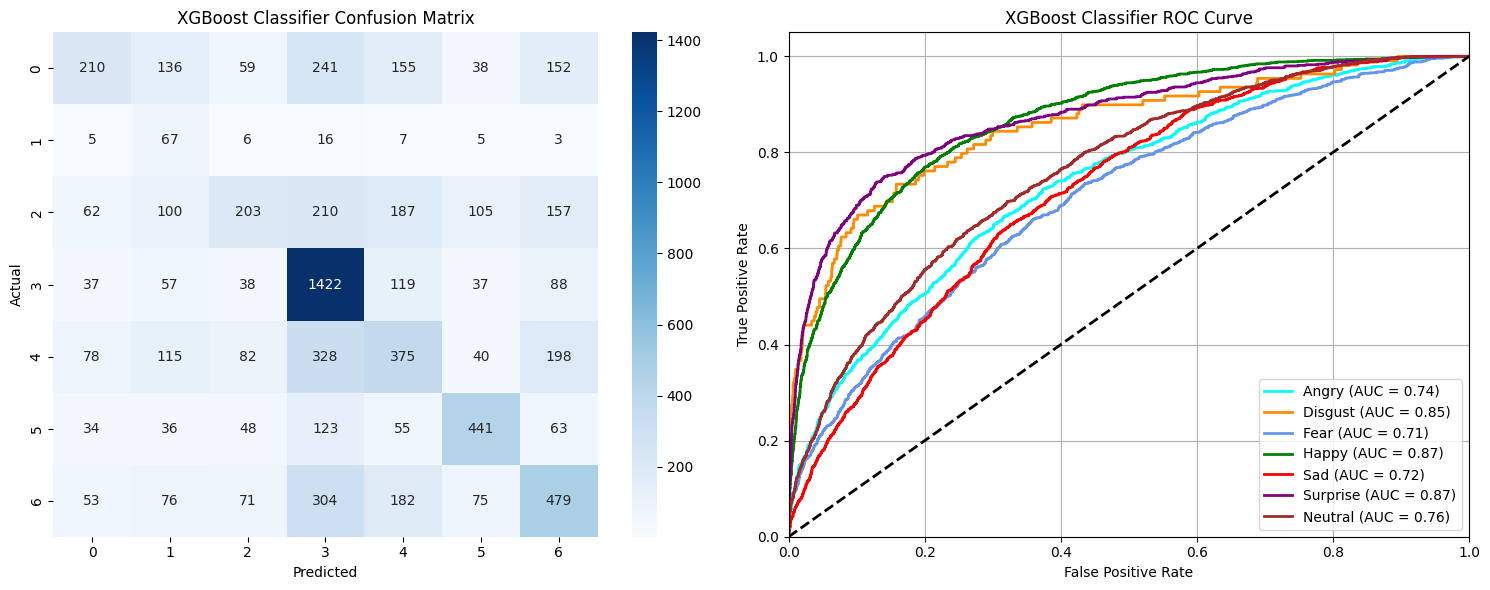

In [ ]:
evaluate_and_plot(xgb_processed, X_test_processed, y_test, title_prefix="XGBoost Classifier", emotions=emotions)

### 4.2 Support Vector Machine Classifier

In [ ]:
svm_org, svm_processed = algorithms["svm"]

#### 4.2.1 Original Data

Support Vector Machine Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.22      0.29       991
           1       1.00      0.02      0.04       109
           2       0.38      0.22      0.28      1024
           3       0.49      0.75      0.59      1798
           4       0.34      0.41      0.37      1216
           5       0.64      0.52      0.57       800
           6       0.42      0.40      0.41      1240

    accuracy                           0.45      7178
   macro avg       0.53      0.36      0.36      7178
weighted avg       0.45      0.45      0.43      7178



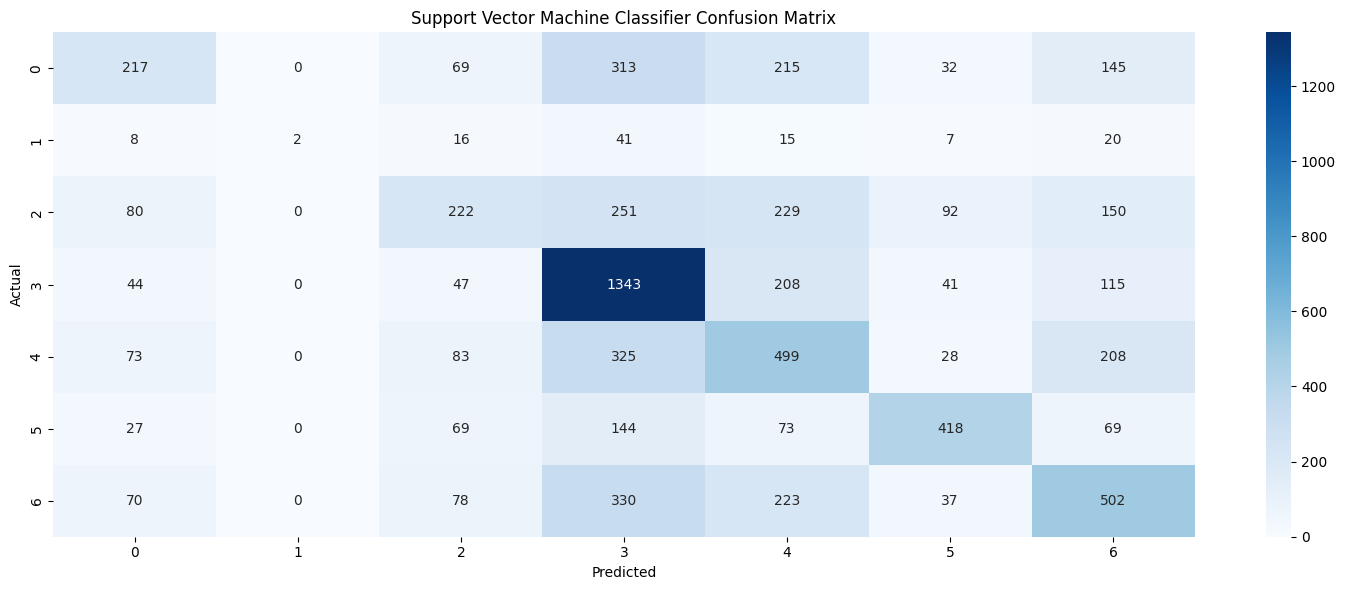

In [ ]:
evaluate_and_plot(svm_org, X_test_org, y_test, title_prefix="Support Vector Machine Classifier", emotions=emotions, is_plot_roc=False)

#### 4.2.2 Processed Data

Support Vector Machine Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.47      0.47       991
           1       0.57      0.46      0.51       109
           2       0.47      0.43      0.45      1024
           3       0.70      0.79      0.75      1798
           4       0.45      0.45      0.45      1216
           5       0.73      0.69      0.71       800
           6       0.53      0.49      0.51      1240

    accuracy                           0.57      7178
   macro avg       0.56      0.54      0.55      7178
weighted avg       0.57      0.57      0.57      7178



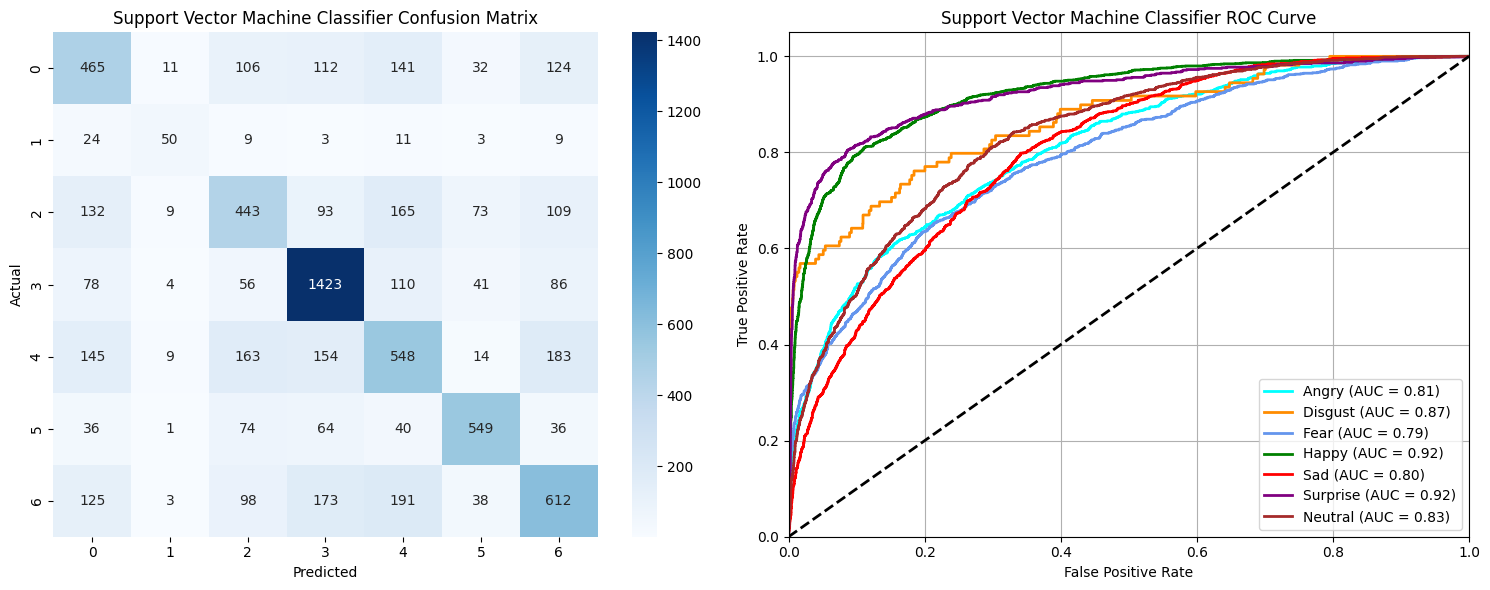

In [ ]:
evaluate_and_plot(svm_processed, X_test_processed, y_test, title_prefix="Support Vector Machine Classifier", emotions=emotions)

### 4.3 Random Forest Classifier

In [ ]:
rf_org, rf_processed = algorithms["Random Forest Classifier"]

#### 4.3.1 Original Data

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    2.3s finished


Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.21      0.30       991
           1       1.00      0.27      0.42       109
           2       0.55      0.29      0.38      1024
           3       0.47      0.81      0.59      1798
           4       0.38      0.40      0.39      1216
           5       0.70      0.60      0.65       800
           6       0.47      0.42      0.44      1240

    accuracy                           0.49      7178
   macro avg       0.59      0.43      0.45      7178
weighted avg       0.51      0.49      0.47      7178



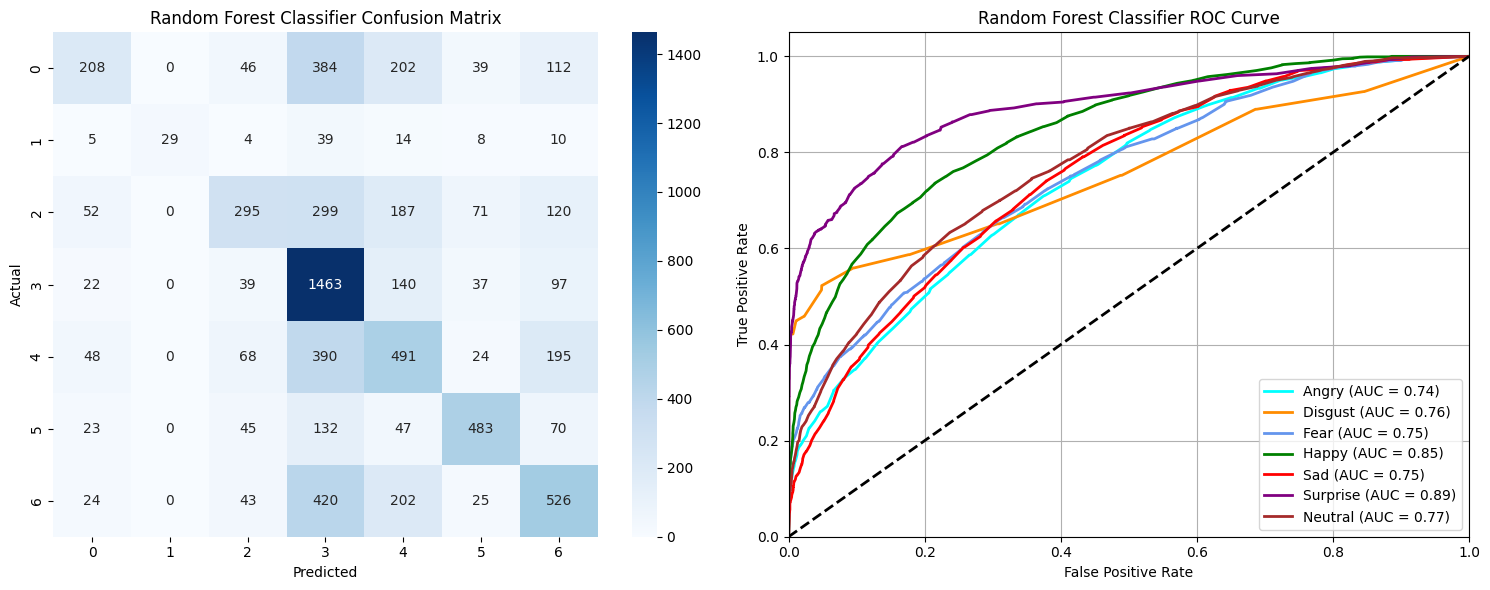

In [ ]:
evaluate_and_plot(rf_org, X_test_org, y_test, title_prefix="Random Forest Classifier", emotions=emotions)

#### 4.3.2 Processed data

Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.18      0.28       991
           1       0.28      0.55      0.37       109
           2       0.56      0.25      0.35      1024
           3       0.45      0.90      0.60      1798
           4       0.41      0.32      0.36      1216
           5       0.79      0.52      0.63       800
           6       0.45      0.41      0.43      1240

    accuracy                           0.48      7178
   macro avg       0.51      0.45      0.43      7178
weighted avg       0.52      0.48      0.45      7178



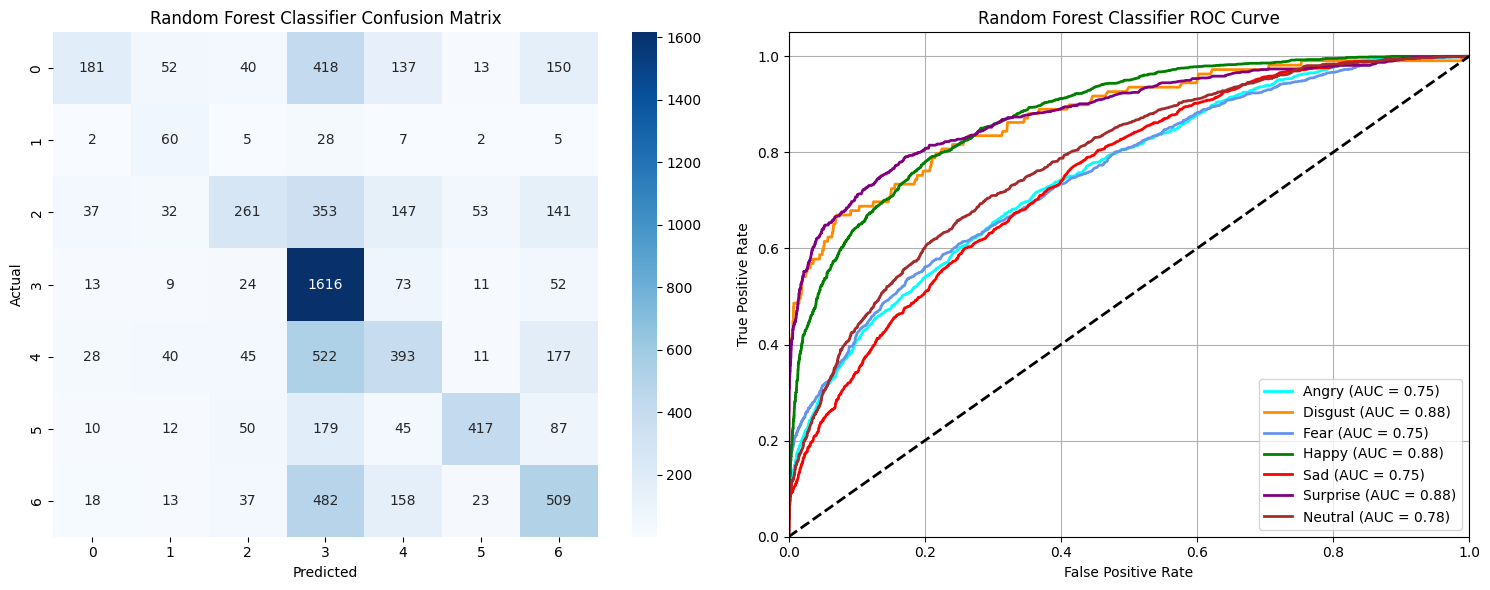

In [ ]:
evaluate_and_plot(rf_processed, X_test_processed, y_test, title_prefix="Random Forest Classifier", emotions=emotions)

### 4.4 Multi-layers Perceptron Classifier

#### 4.4.1 Original Data

In [ ]:
mlp_org, mlp_processed = algorithms["Multi-layers Perceptron Classifier"]

  1/225 [..............................] - ETA: 6s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


225/225 [==============================] - 2s 8ms/step
Multi-layers Perceptron Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       991
           1       0.00      0.00      0.00       109
           2       0.12      0.00      0.01      1024
           3       0.26      0.98      0.41      1798
           4       0.36      0.08      0.13      1216
           5       0.67      0.07      0.12       800
           6       0.28      0.01      0.02      1240

    accuracy                           0.27      7178
   macro avg       0.24      0.16      0.10      7178
weighted avg       0.27      0.27      0.14      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


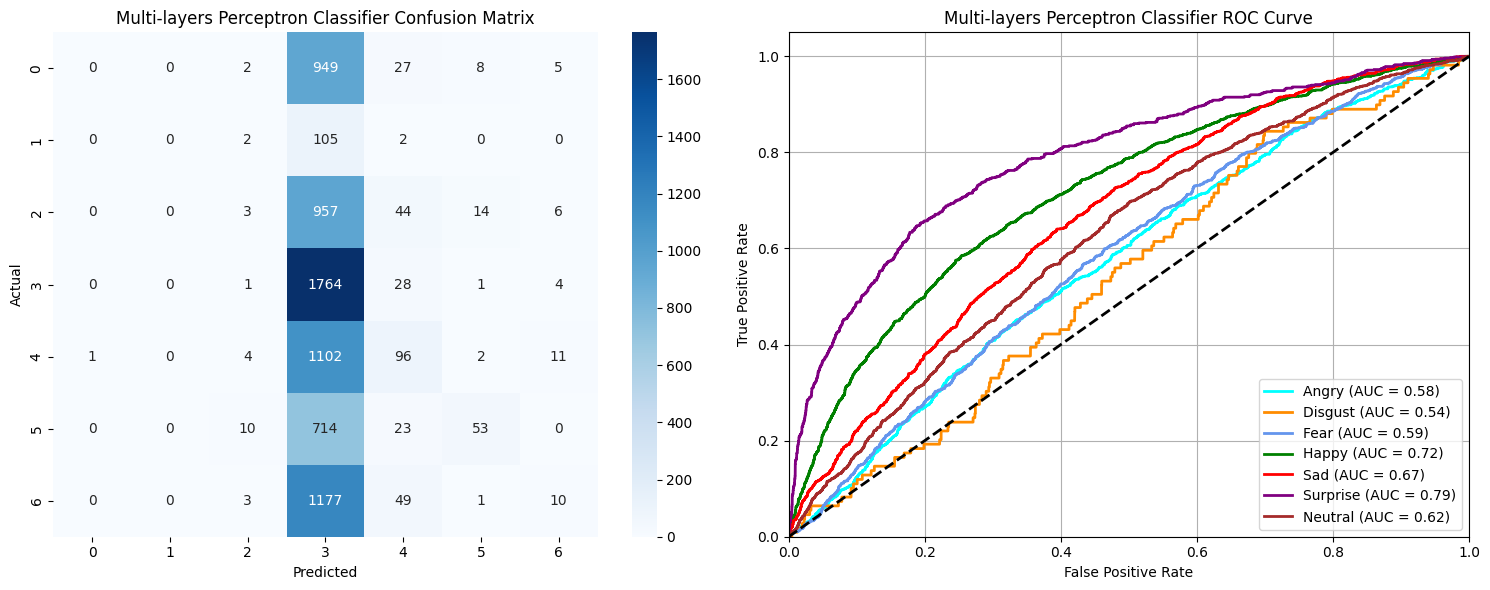

In [ ]:
evaluate_and_plot(mlp_org, X_test_org, y_test, title_prefix="Multi-layers Perceptron Classifier", emotions=emotions, is_tf_model=True)

#### 4.4.2 Processed Data

 17/225 [=>............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


225/225 [==============================] - 2s 7ms/step
Multi-layers Perceptron Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.28      0.33       991
           1       0.33      0.01      0.02       109
           2       0.34      0.14      0.20      1024
           3       0.60      0.77      0.67      1798
           4       0.33      0.40      0.36      1216
           5       0.56      0.57      0.57       800
           6       0.41      0.47      0.44      1240

    accuracy                           0.47      7178
   macro avg       0.42      0.38      0.37      7178
weighted avg       0.45      0.47      0.44      7178



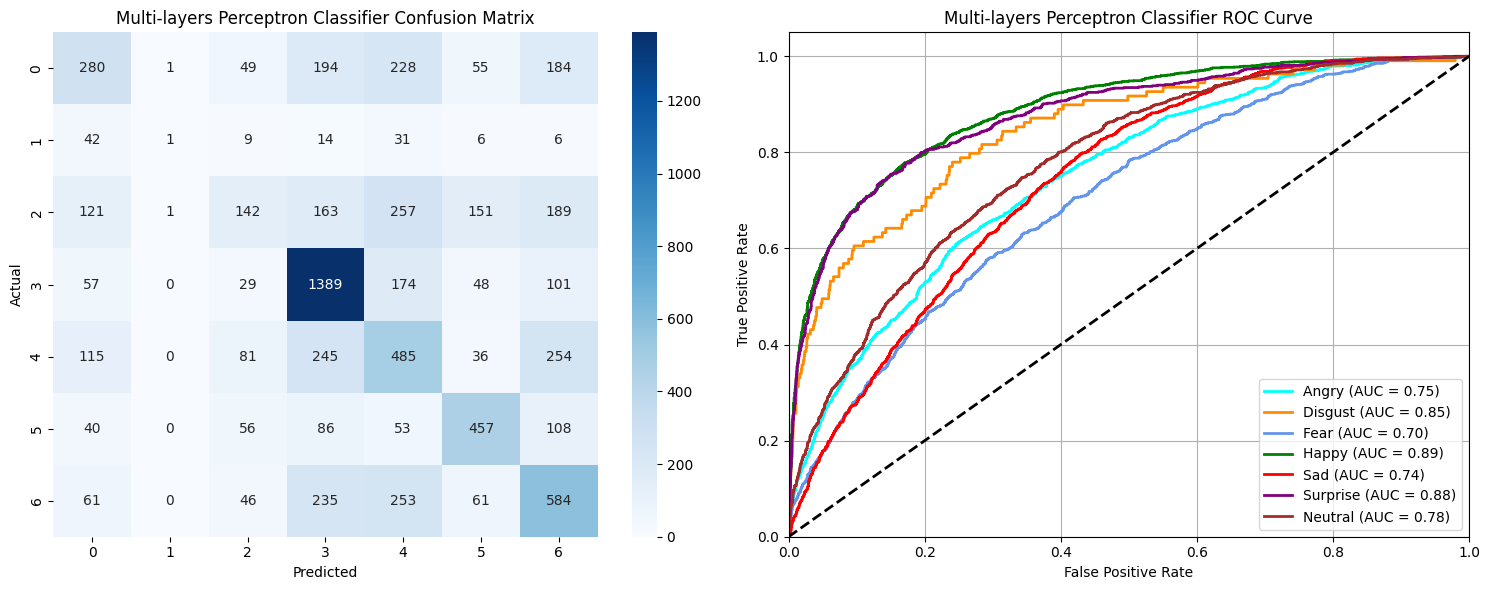

In [ ]:
evaluate_and_plot(mlp_processed, X_test_processed, y_test, title_prefix="Multi-layers Perceptron Classifier", emotions=emotions, is_tf_model=True)

## Conclusion

###A. In General

####1. About the Data:

- **Processed Data**: Across all models, the dataset with processed features consistently outperformed the original data. This enhancement suggests that feature engineering techniques such as HOG (Histogram of Oriented Gradients), PCA (Principal Component Analysis), and scaling play a crucial role in improving model performance for image classification tasks.

- **Original Data**: Among all, the dataset with original, unprocessed features generally showed lower performance compared to the processed data. This suggests that without feature engineering techniques such as HOG (Histogram of Oriented Gradients), PCA (Principal Component Analysis), and scaling, the models struggled to effectively capture and differentiate the complex patterns present in the ICML Face Data.

###2. About the Models

- XGBoost and RandomForest: These ensemble methods benefited significantly from the processed data, leveraging feature transformations and dimensionality reduction provided by PCA to enhance their ability to capture complex patterns in the data.

- SVC and MLP: Both models also showed marked improvement on the processed dataset, indicating that feature preprocessing helped in better generalization and discrimination between classes for these algorithms.

###B. In Detail

####1. Extreme Gradient Boosting (XGBoost)
- XGBoost stands out as exceptionally effective when applied to processed data. The ROC analysis reveals that even with the original data, the model showed promising average AUC values ranging from 0.61 ("Disgust") to 0.81 ("Surprise").

- Upon integrating processed features like HOG, PCA, and scaling, XGBoost's performance significantly improved. AUC values saw an impressive uplift across all classes, with increases of up to 0.10. Notably, "Disgust" exhibited the most substantial improvement, soaring from 0.62 to 0.85, while "Surprise" remained highest at 0.87.

####2. Support Vector Classifier (SVC)
- SVC also demonstrated enhanced accuracy, rising notably from approximately 44% to around 57% with processed data, marking an improvement of approximately 13%.

- AUC ratings for each class were consistently high in the processed data scenario, with "Surprise" and "Happy" achieving the highest ratings of 0.92, and "Fear" registering the lowest at 0.79.

####3. Random Forest Classifier (RFC)
- As an ensemble model, Random Forest Classifier exhibited reliable performance. Its confusion matrix showcased better precision in predicting class label 3 compared to other models.

- AUC ratings were consistently acceptable, ranging from 0.75 to 0.88, indicating robust discriminative ability across various emotion classes.

####4. Multi-layer Perceptron Classifier (MLPC)
- MLPC demonstrated a significant performance boost of approximately 20% with processed data, suggesting its potential for more complex and spacious datasets.

- While AUC values did not stand out as prominently compared to other models, all remained above 0.7, indicating reliable performance across all emotion classes.